In [80]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

with open("cor.csv") as file_name:
    array = np.loadtxt(file_name, delimiter=",",dtype = str)

cor_data ='cor.csv'
df_cor = pd.read_csv(cor_data,skipinitialspace=True)


df_cor=df_cor.values
df_cor
# with open("el.csv") as file_name:
#     array = np.loadtxt(file_name, delimiter=",")
# array

array([[  17.,   22.],
       [  17.,   59.],
       [  17.,   96.],
       ...,
       [ 615., 1136.],
       [ 615., 1137.],
       [ 615., 1138.]])

In [81]:
# array_1= array[~np.isnan(array).any(axis=1)]
# array_1


In [82]:
# ddf_cor=df_cor[0:1000]
rng = np.random.default_rng()
ddf_cor = rng.choice(df_cor, 200)
ddf_cor

array([[ 468.,  430.],
       [ 176.,  852.],
       [ 132., 1418.],
       [ 498.,  400.],
       [ 199., 1419.],
       [ 295.,  293.],
       [ 102., 1246.],
       [ 535.,  555.],
       [ 306.,  603.],
       [   6.,  630.],
       [ 192., 1319.],
       [  24.,   12.],
       [  32., 1476.],
       [ 189.,  545.],
       [ 396.,  840.],
       [   7., 1175.],
       [ 353., 1088.],
       [ 337., 1623.],
       [ 602.,  576.],
       [  21., 1645.],
       [  62., 1550.],
       [  57.,  192.],
       [  81.,  600.],
       [  91., 1210.],
       [ 283.,  516.],
       [ 515., 1046.],
       [ 497.,  186.],
       [ 390.,  568.],
       [  92., 1165.],
       [ 602.,  586.],
       [  29.,  150.],
       [ 182., 1338.],
       [ 509., 1572.],
       [ 429.,  249.],
       [ 188.,  196.],
       [ 250., 1471.],
       [ 455.,  853.],
       [ 531.,  661.],
       [ 373.,  317.],
       [ 541.,  662.],
       [  19.,  731.],
       [ 213., 1011.],
       [ 188.,  305.],
       [ 27

In [83]:
# vdf_cor=df_cor[5000:10000]
vdf_cor = rng.choice(df_cor, 100)


In [92]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize

''' sampling via multivariate normal distribution with no trend '''
"""
cov: variance-covariance matrix
"""
def gen_multivariate_normal(cov):
    print("--gen_multivariate_normal()--")
    L = np.linalg.cholesky(cov)
    z = np.random.standard_normal(len(cov))

    return np.dot(L, z)

'''variance-covariance matrix for log-normal shadowing'''
"""
x, y:  vector for measurement location
dcor:  correlation distance of shadowing [m]
sigma: standard deviation [dB]
"""
def gen_varcov_matrix(x, y, dcor, sigma):
    print("--gen_varcov_matrix()--")
    dmat = distance(x, y, x[:, np.newaxis], y[:, np.newaxis]) # distance matrix
    tmp  = 0.6931471805599453 / dcor                          # np.log(2.0)/dcor

    return sigma * sigma * np.exp(-dmat * tmp)

'''for measurement location'''
"""
n_node:   number of nodes
len_area: area length [m]
"""
def gen_location_vector(n_node, len_area):
    print("--gen_location_vector()--")
    x = np.random.uniform(0.0, len_area, n_node)
    y = np.random.uniform(0.0, len_area, n_node)
    
    return x, y

''' gen empirical semivariogram via binning '''
def gen_emprical_semivar(data, d_max, num):
    def gen_combinations(arr):
      r, c = np.triu_indices(len(arr), 1)

      return np.stack((arr[r], arr[c]), 1)

    print("--gen_emprical_semivar()--")
    d_semivar   = np.linspace(0.0, d_max, num)
    SPAN        = d_semivar[1] - d_semivar[0]

    indx        = gen_combinations(np.arange(N))
    
    '''gen semivariogram clouds'''
    d           = distance(data[indx[:, 0], 0], data[indx[:, 0], 1], data[indx[:, 1], 0], data[indx[:, 1], 1])
    indx        = indx[d<=d_max]
    d           = d[d <= d_max]
    semivar     = (data[indx[:, 0], 2] - data[indx[:, 1], 2])**2

    '''average semivariogram clouds via binning'''
    semivar_avg = np.empty(num)
    for i in range(num):
        d1 = d_semivar[i] - 0.5*SPAN
        d2 = d_semivar[i] + 0.5*SPAN
        indx_tmp = (d1 < d) * (d <= d2) #index within calculation span
        semivar_tr = semivar[indx_tmp]
        # semivar_avg[i] = semivar_tr.mean()
        if len(semivar_tr)>0:
            semivar_avg[i] = semivar_tr.mean()
        else:
            semivar_avg[i] = np.nan

    return d_semivar[np.isnan(semivar_avg) == False], 0.5 * semivar_avg[np.isnan(semivar_avg) == False]

'''theoretical semivariogram (exponential)'''
def semivar_exp(d, nug, sill, ran):
    return np.abs(nug) + np.abs(sill) * (1.0-np.exp(-d/(np.abs(ran))))

'''fitting emperical semivariotram to theoretical model'''
def fit_semivar(d, data):
    def obj_func(x):
        theorem = semivar_exp(d, x[0], x[1], x[2])

        return ((data-theorem)**2).sum()

    x0  = np.random.uniform(0.0, 1.0, 3)
    res = minimize(obj_func, x0, method='nelder-mead')
    for i in range(5):
        x0      = np.random.uniform(0.0, 1.0, 3)
        res_tmp = minimize(obj_func, x0, method='nelder-mead')
        if res.fun > res_tmp.fun:
            res = res_tmp

    return np.abs(res.x)

def ordinary_kriging(mat, x_vec, y_vec, z_vec, x_rx, y_rx, nug, sill, ran):
    vec              = np.ones(len(z_vec)+1, dtype=float)

    d_vec            = distance(x_vec, y_vec, x_rx, y_rx)
    vec[:len(z_vec)] = semivar_exp(d_vec, nug, sill, ran)
    weight           = np.linalg.solve(mat, vec)
    est              = (z_vec * weight[:len(z_vec)]).sum()

    return est

def distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

'''matrix for weight calculation in Ordinary Kriging'''
def gen_mat_for_kriging(x_vec, y_vec, z_vec, nug, sill, ran):
    mat = distance(x_vec, y_vec, x_vec[:, np.newaxis], y_vec[:, np.newaxis])
    mat = semivar_exp(mat, nug, sill, ran)
    mat = np.vstack((mat, np.ones(len(z_vec))))
    mat = np.hstack((mat, np.ones([len(z_vec)+1, 1])))
    mat[len(z_vec)][len(z_vec)] = 0.0

    return mat

def pathloss(d, eta):
    return 10.0 * eta * np.log10(d+1.0) #+1: to avoid diverse of path loss

'''Ordinary Least Squares for Path Loss Modeling'''
def OLS(d, p):
    A       = np.vstack([-10.0*np.log10(d+1.0), np.ones(len(p))]).T
    m, c    = np.linalg.lstsq(A, p, rcond=None)[0]
    return m, c

--gen_varcov_matrix()--
--gen_multivariate_normal()--
--gen_emprical_semivar()--


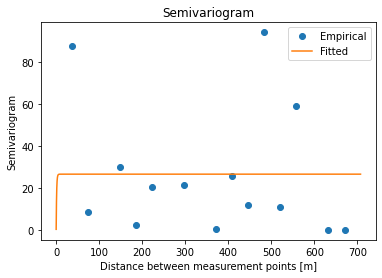

In [96]:
aa = "12345"

if len(aa)>0:
    '''measurement configuration'''
    LEN_AREA    = 500.0            #area length [m]
    N           = 10              #number of samples
    DCOR        = 20.0             #correlation distance [m]
    STDEV       = 8.0              #standard deviation
    TX_X        = 0.0              #x coordinate of transmitter
    TX_Y        = 0.5 * LEN_AREA   #y coordinate of transmitter
    PTX         = 30.0             #transmission power [dBm]
    ETA         = 3.0              #path loss index

    '''parameters for semivariogram modeling and Kriging'''
    D_MAX       = LEN_AREA * np.sqrt(2.0) #maximum distance in semivariogram modeling
    N_SEMIVAR   = 20                      #number for averaging empirical semivariograms
    
    '''get measurement dataset'''

    x, y    = ddf_cor.T
 
    
    cov     = gen_varcov_matrix(x, y, DCOR, STDEV)

    z       = gen_multivariate_normal(cov)  #correlated shadowing vector[dB]

    d       = distance(TX_X, TX_Y, x, y)
    l       = pathloss(d, ETA)              #[dB]
    prx     = PTX - l + z                   #received signal power [dBm]

    '''path loss modeling'''
    eta_est, ptx_est = OLS(d, prx)

    '''regression-based shadowing extraction'''
    pmean_est   = ptx_est - pathloss(d, eta_est)
    shad_est    = prx - pmean_est

    '''get empirical semivariogram model'''
    data        = np.vstack([x, y, shad_est]).T
    d_sv, sv    = gen_emprical_semivar(data, D_MAX, N_SEMIVAR)
    param       = fit_semivar(d_sv, sv)

    '''plot empirical/theoretical semivariogram'''
    d_fit = np.linspace(0.0, D_MAX, 1000)
    y_fit = semivar_exp(d_fit, param[0], param[1], param[2])
    plt.plot(d_sv, sv, 'o', label="Empirical")
    plt.plot(d_fit, y_fit, label="Fitted")
    plt.title("Semivariogram")
    plt.xlabel("Distance between measurement points [m]")
    plt.ylabel("Semivariogram")
    plt.legend()
    plt.show()

<ipython-input-97-f3266ac869cd>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = axs[1].pcolor(X, Y, prx_map, cmap='jet', vmin=int(np.min(prx))-1, vmax=int(np.max(prx))+1)


(200,) (200,) (200,) (10, 10) (10, 10) (10, 10)


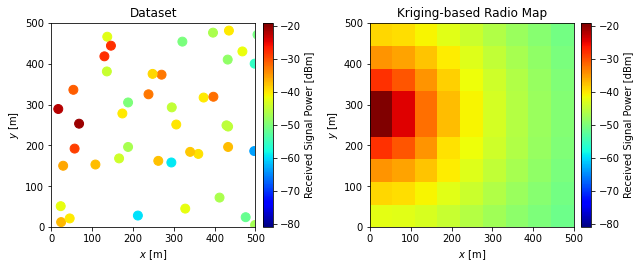

In [97]:
'''radio map construction'''
N_DIV   = 10 #number of grids in each axis
x_valid = np.linspace(0, LEN_AREA, N_DIV)
y_valid = np.linspace(0, LEN_AREA, N_DIV)
X, Y    = np.meshgrid(x_valid, y_valid)
prx_map = np.zeros([len(x_valid), len(y_valid)])
    
mat     = gen_mat_for_kriging(x, y, prx, param[0], param[1], param[2])

for i in range(len(y_valid)):
    for j in range(len(x_valid)):
        d_tmp           = distance(TX_X, TX_Y, x_valid[j], y_valid[i])
        pmean           = ptx_est - pathloss(d_tmp, eta_est)
        prx_map[i][j]   = pmean + ordinary_kriging(mat, x, y, shad_est, x_valid[j], y_valid[i], param[0], param[1], param[2])

'''plot results'''
fig, axs = plt.subplots(1, 2, figsize=(9, 6))

im0 = axs[0].scatter(x, y, s=80, c=prx, cmap='jet', vmin=int(np.min(prx))-1, vmax=int(np.max(prx))+1)
im1 = axs[1].pcolor(X, Y, prx_map, cmap='jet', vmin=int(np.min(prx))-1, vmax=int(np.max(prx))+1)

axs[0].set_title("Dataset")
axs[0].set_xlim([0.0, LEN_AREA])
axs[0].set_ylim([0.0, LEN_AREA])
axs[0].set_xlabel("$x$ [m]")
axs[0].set_ylabel("$y$ [m]")
axs[0].set_aspect('equal')
divider = make_axes_locatable(axs[0])
cax     = divider.append_axes("right", size="5%", pad=0.1)
cb      = fig.colorbar(im0, ax=axs[0], cax=cax)
cb.set_label("Received Signal Power [dBm]")

axs[1].set_title("Kriging-based Radio Map")
axs[1].set_xlim([0.0, LEN_AREA])
axs[1].set_ylim([0.0, LEN_AREA])
axs[1].set_xlabel("$x$ [m]")
axs[1].set_ylabel("$y$ [m]")
axs[1].set_aspect('equal')
divider = make_axes_locatable(axs[1])
cax     = divider.append_axes("right", size="5%", pad=0.1)
cb      = fig.colorbar(im1, ax=axs[1], cax=cax)
cb.set_label("Received Signal Power [dBm]")

plt.tight_layout()
# plt.show()
plt.savefig("example.png", bbox_inches="tight")
    
print(np.shape(x), np.shape(y), np.shape(prx), np.shape(X), np.shape(Y), np.shape(prx_map))


In [95]:
import numpy as np
from pykrige.rk import Krige
from sklearn.model_selection import GridSearchCV


# 2D Kring param opt

param_dict = {
    "method": ["ordinary", "universal"],
    "variogram_model": ["linear", "power", "gaussian", "spherical"],
    # "nlags": [4, 6, 8],
    # "weight": [True, False]
}

estimator = GridSearchCV(Krige(), param_dict, verbose=True, return_train_score=True)

# dummy data
X = 
y = 5 * np.random.rand(100)

# run the gridsearch
estimator.fit(X=X, y=y)


if hasattr(estimator, "best_score_"):
    print("best_score R² = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

print("\nCV results::")
if hasattr(estimator, "cv_results_"):
    for key in [
        "mean_test_score",
        "mean_train_score",
        "param_method",
        "param_variogram_model",
    ]:
        print(" - {} : {}".format(key, estimator.cv_results_[key]))

SyntaxError: invalid syntax (<ipython-input-95-48f73d0798f7>, line 18)

## Radio Map Construction with Regression Kriging

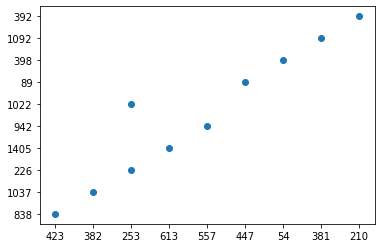

In [110]:

x = [row[0] for row in array]
y = [row[1] for row in array]

plt.scatter(x,y)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize

''' sampling via multivariate normal distribution with no trend '''
"""
cov: variance-covariance matrix
"""
def gen_multivariate_normal(cov):
    print("--gen_multivariate_normal()--")
    L = np.linalg.cholesky(cov)
    z = np.random.standard_normal(len(cov))

    return np.dot(L, z)

'''variance-covariance matrix for log-normal shadowing'''
"""
x, y:  vector for measurement location
dcor:  correlation distance of shadowing [m]
sigma: standard deviation [dB]
"""
def gen_varcov_matrix(x, y, dcor, sigma):
    print("--gen_varcov_matrix()--")
    dmat = distance(x, y, x[:, np.newaxis], y[:, np.newaxis]) # distance matrix
    tmp  = 0.6931471805599453 / dcor                          # np.log(2.0)/dcor

    return sigma * sigma * np.exp(-dmat * tmp)

'''for measurement location'''
"""
n_node:   number of nodes
len_area: area length [m]
"""
def gen_location_vector(n_node, len_area):
    print("--gen_location_vector()--")
    x = np.random.uniform(0.0, len_area, n_node)
    y = np.random.uniform(0.0, len_area, n_node)
    
    return x, y

''' gen empirical semivariogram via binning '''
def gen_emprical_semivar(data, d_max, num):
    def gen_combinations(arr):
      r, c = np.triu_indices(len(arr), 1)

      return np.stack((arr[r], arr[c]), 1)

    print("--gen_emprical_semivar()--")
    d_semivar   = np.linspace(0.0, d_max, num)
    SPAN        = d_semivar[1] - d_semivar[0]

    indx        = gen_combinations(np.arange(N))
    
    '''gen semivariogram clouds'''
    d           = distance(data[indx[:, 0], 0], data[indx[:, 0], 1], data[indx[:, 1], 0], data[indx[:, 1], 1])
    indx        = indx[d<=d_max]
    d           = d[d <= d_max]
    semivar     = (data[indx[:, 0], 2] - data[indx[:, 1], 2])**2

    '''average semivariogram clouds via binning'''
    semivar_avg = np.empty(num)
    for i in range(num):
        d1 = d_semivar[i] - 0.5*SPAN
        d2 = d_semivar[i] + 0.5*SPAN
        indx_tmp = (d1 < d) * (d <= d2) #index within calculation span
        semivar_tr = semivar[indx_tmp]
        # semivar_avg[i] = semivar_tr.mean()
        if len(semivar_tr)>0:
            semivar_avg[i] = semivar_tr.mean()
        else:
            semivar_avg[i] = np.nan

    return d_semivar[np.isnan(semivar_avg) == False], 0.5 * semivar_avg[np.isnan(semivar_avg) == False]

'''theoretical semivariogram (exponential)'''
def semivar_exp(d, nug, sill, ran):
    return np.abs(nug) + np.abs(sill) * (1.0-np.exp(-d/(np.abs(ran))))

'''fitting emperical semivariotram to theoretical model'''
def fit_semivar(d, data):
    def obj_func(x):
        theorem = semivar_exp(d, x[0], x[1], x[2])

        return ((data-theorem)**2).sum()

    x0  = np.random.uniform(0.0, 1.0, 3)
    res = minimize(obj_func, x0, method='nelder-mead')
    for i in range(5):
        x0      = np.random.uniform(0.0, 1.0, 3)
        res_tmp = minimize(obj_func, x0, method='nelder-mead')
        if res.fun > res_tmp.fun:
            res = res_tmp

    return np.abs(res.x)

def ordinary_kriging(mat, x_vec, y_vec, z_vec, x_rx, y_rx, nug, sill, ran):
    vec              = np.ones(len(z_vec)+1, dtype=float)

    d_vec            = distance(x_vec, y_vec, x_rx, y_rx)
    vec[:len(z_vec)] = semivar_exp(d_vec, nug, sill, ran)
    weight           = np.linalg.solve(mat, vec)
    est              = (z_vec * weight[:len(z_vec)]).sum()

    return est

def distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

'''matrix for weight calculation in Ordinary Kriging'''
def gen_mat_for_kriging(x_vec, y_vec, z_vec, nug, sill, ran):
    mat = distance(x_vec, y_vec, x_vec[:, np.newaxis], y_vec[:, np.newaxis])
    mat = semivar_exp(mat, nug, sill, ran)
    mat = np.vstack((mat, np.ones(len(z_vec))))
    mat = np.hstack((mat, np.ones([len(z_vec)+1, 1])))
    mat[len(z_vec)][len(z_vec)] = 0.0

    return mat

def pathloss(d, eta):
    return 10.0 * eta * np.log10(d+1.0) #+1: to avoid diverse of path loss

'''Ordinary Least Squares for Path Loss Modeling'''
def OLS(d, p):
    A       = np.vstack([-10.0*np.log10(d+1.0), np.ones(len(p))]).T
    m, c    = np.linalg.lstsq(A, p, rcond=None)[0]
    return m, c

In [140]:
aa = "12345"

if len(aa)>0:
    '''measurement configuration'''
    LEN_AREA    = 200.0            #area length [m]
    N           = 10              #number of samples
    DCOR        = 20.0             #correlation distance [m]
    STDEV       = 8.0              #standard deviation
    TX_X        = 0.0              #x coordinate of transmitter
    TX_Y        = 0.5 * LEN_AREA   #y coordinate of transmitter
    PTX         = 30.0             #transmission power [dBm]
    ETA         = 3.0              #path loss index

    '''parameters for semivariogram modeling and Kriging'''
    D_MAX       = LEN_AREA * np.sqrt(2.0) #maximum distance in semivariogram modeling
    N_SEMIVAR   = 20                      #number for averaging empirical semivariograms
    
    '''get measurement dataset'''

    x, y    = gen_location_vector(N, LEN_AREA)
x, y
#     cov     = gen_varcov_matrix(x, y, DCOR, STDEV)
#     z       = gen_multivariate_normal(cov)  #correlated shadowing vector[dB]

#     d       = distance(TX_X, TX_Y, x, y)
#     l       = pathloss(d, ETA)              #[dB]
#     prx     = PTX - l + z                   #received signal power [dBm]

#     '''path loss modeling'''
#     eta_est, ptx_est = OLS(d, prx)

#     '''regression-based shadowing extraction'''
#     pmean_est   = ptx_est - pathloss(d, eta_est)
#     shad_est    = prx - pmean_est

#     '''get empirical semivariogram model'''
#     data        = np.vstack([x, y, shad_est]).T
#     d_sv, sv    = gen_emprical_semivar(data, D_MAX, N_SEMIVAR)
#     param       = fit_semivar(d_sv, sv)

#     '''plot empirical/theoretical semivariogram'''
#     d_fit = np.linspace(0.0, D_MAX, 1000)
#     y_fit = semivar_exp(d_fit, param[0], param[1], param[2])
#     plt.plot(d_sv, sv, 'o', label="Empirical")
#     plt.plot(d_fit, y_fit, label="Fitted")
#     plt.title("Semivariogram")
#     plt.xlabel("Distance between measurement points [m]")
#     plt.ylabel("Semivariogram")
#     plt.legend()
#     plt.show()

--gen_location_vector()--


(array([199.09663832, 140.27209049,  26.63511036,  86.01301935,
        179.31994309, 145.61140574, 163.72334437, 189.26281491,
         74.89425951,  69.36791455]),
 array([ 44.10242714,  78.7483042 ,   7.64285765,  73.63995718,
         37.50720029,  12.5197067 , 184.73336016, 100.87637027,
         79.15463981,  15.43523177]))

In [ ]:
array([192.81122883, 129.84739664,  19.18720397,  36.32415541,
        70.36819458, 112.19482526, 199.06871599,  49.34257728,
       126.39133466,  32.36957184])